In [33]:
import os

interface_dir = os.environ["DATA"] + "webinterfaces/int05_prototype/"

tasks_dir = os.path.join(interface_dir, "res", "tasks")

results_dir = os.path.join(interface_dir, "results")
protocols_dir = os.path.join(interface_dir, "protocols")

results_filenames_d = {
    "CF": ["vgjml6bp.json", "ccddeeffgghh.json"],
    "SHAP": ["9qs2oelz.json", "bora.json", "ggwmlvei.json"],
    "H": ["bkbcgvyd.json", "c5eblx4w.json", "lhrapnar.json", "rd1nxuhy.json", "tcq3r4vd.json", "ccMonKatCObi1!.json"],
    "AI": ["bb2fgdunby.json"],
}

protocol_paths_d = {
    "CF": os.path.join(protocols_dir, "XAI_CF_0.json"),
    "SHAP": os.path.join(protocols_dir, "XAI_SHAP_0.json"),
    "H": os.path.join(protocols_dir, "H_0.json"),
    "AI": os.path.join(protocols_dir, "AI_0.json"),
}

EASY_TASKS = ["med5_find_pattern", "med2_yellow_square_N", "med6_find_pattern", "med4_blue_triangle_N"]
EASY_TASKS = ["med5_find_pattern", "med6_find_pattern"]
DIFFICULT_TASKS = ["hard5_find_pattern", "hard2_blue_circle_N", "hard6_find_pattern", "hard4_yellow_square_N"]
DIFFICULT_TASKS = ["hard5_find_pattern", "hard6_find_pattern"]

MILD_PRESSURE_TASKS = ["med5_find_pattern", "med2_yellow_square_N", "hard5_find_pattern", "hard2_blue_circle_N"]
MILD_PRESSURE_TASKS = ["med5_find_pattern", "hard5_find_pattern"]
STRONG_PRESSURE_TASKS = ["med6_find_pattern", "hard6_find_pattern"]

FIND_PATTERNS_TASKS = ["med5_find_pattern", "med6_find_pattern", "hard5_find_pattern", "hard6_find_pattern"]
COUNT_SYMBOLS_TASKS = ["med2_yellow_square_N", "med4_blue_triangle_N", "hard2_blue_circle_N", "hard4_yellow_square_N"]
COUNT_SYMBOLS_TASKS = []

TASK_PROTOCOL_KEYS = {
    "med5_find_pattern": "mainexp_easy5_pat_task",
    "med2_yellow_square_N": "mainexp_easy2_N_task",
    "med6_find_pattern": "mainexp_easy6_pat_task",
    "med4_blue_triangle_N": "mainexp_easy4_N_task",

    "hard5_find_pattern": "mainexp_hard5_pat_task",
    "hard2_blue_circle_N": "mainexp_hard2_N_task",
    "hard6_find_pattern": "mainexp_hard6_pat_task",
    "hard4_yellow_square_N": "mainexp_hard4_N_task"
}



In [34]:
import sys

sys.path.append("/home/jleguy/Documents/postdoc/git_repos/WebXAII/")

In [35]:
import json
import csv
import numpy as np


def load_json(path):
    with open(path) as json_file:
        return json.load(json_file)


def load_task_csv_file(path):
    y_true, y_pred = [], []
    with open(path) as csv_data:
        reader = csv.DictReader(csv_data)
        for row in reader:
            y_true.append(int(row["target"]))
            y_pred.append(int(row["pred"]))

    return np.array(y_true), np.array(y_pred)


In [36]:
from pywebxaii.resretrieval import extract_p_task_results


def compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, tasks_names, task_protocol_keys):
    output_res_scores_d = {}
    output_res_reliance_d = {}
    output_res_overreliance_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_scores_d[group_key] = []
        output_res_reliance_d[group_key] = []
        output_res_overreliance_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)

            nb_questions = 0
            nb_quest_wrong_predictions = 0
            nb_correct = 0
            nb_reliance = 0
            nb_overreliance = 0
            early_break = False

            # Iterating over all tasks
            for task_idx, task_name in enumerate(tasks_names):

                task_true, ai_pred = load_task_csv_file(os.path.join(tasks_dir, task_name + "_content.csv"))

                answers_idx_vect, answers_text_vect, _, _, _ = \
                    extract_p_task_results(load_json(curr_res_path),
                                           task_protocol_keys[tasks_names[task_idx]],
                                           protocol_d=load_json(protocol_paths_d[group_key]))

                nb_questions += len(answers_idx_vect)
                nb_quest_wrong_predictions += np.sum(task_true != ai_pred)

                try:
                    nb_correct += np.sum(answers_idx_vect == np.logical_not(task_true))
                    nb_reliance += np.sum(answers_idx_vect == np.logical_not(ai_pred))
                    nb_overreliance += np.sum(np.logical_and(
                        answers_idx_vect == np.logical_not(ai_pred),
                        ai_pred != task_true
                    ))

                    if np.isnan(np.sum(answers_idx_vect)):
                        print(f"answers {answers_idx_vect}")
                        print(f"true {np.logical_not(task_true)}")
                        print(f"ai pred {np.logical_not(ai_pred)}")
                        print(f"correct extracted {np.sum(answers_idx_vect == np.logical_not(task_true))}")
                        print(f"reliance extracted {np.sum(answers_idx_vect == np.logical_not(ai_pred))}")

                # Happens if the results file is not complete
                except ValueError:
                    print("ValueError exception")
                    output_res_scores_d[group_key].append(None)
                    output_res_reliance_d[group_key].append(None)
                    output_res_overreliance_d[group_key].append(None)
                    early_break = True
                    break

            if not early_break:
                output_res_scores_d[group_key].append(nb_correct / nb_questions)
                output_res_reliance_d[group_key].append(nb_reliance / nb_questions)
                output_res_overreliance_d[group_key].append(nb_overreliance / nb_quest_wrong_predictions)

            print(nb_questions)
            print(nb_quest_wrong_predictions)
    return output_res_scores_d, output_res_reliance_d, output_res_overreliance_d


In [38]:
all_scores, all_reliance, all_overreliance = compute_scores(results_dir, results_filenames_d, protocol_paths_d,
                                                            tasks_dir,
                                                            EASY_TASKS + DIFFICULT_TASKS, TASK_PROTOCOL_KEYS)

all_scores_easy, all_reliance_easy, all_overreliance_easy = compute_scores(results_dir, results_filenames_d,
                                                                           protocol_paths_d, tasks_dir,
                                                                           EASY_TASKS, TASK_PROTOCOL_KEYS)

all_scores_difficult, all_reliance_difficult, all_overreliance_difficult = compute_scores(results_dir,
                                                                                          results_filenames_d,
                                                                                          protocol_paths_d,
                                                                                          tasks_dir, DIFFICULT_TASKS,
                                                                                          TASK_PROTOCOL_KEYS)

all_scores_mild, all_reliance_mild, all_overreliance_mild = compute_scores(results_dir, results_filenames_d,
                                                                           protocol_paths_d, tasks_dir,
                                                                           MILD_PRESSURE_TASKS,
                                                                           TASK_PROTOCOL_KEYS)

all_scores_strong, all_reliance_strong, all_overreliance_strong = compute_scores(results_dir, results_filenames_d,
                                                                                 protocol_paths_d, tasks_dir,
                                                                                 STRONG_PRESSURE_TASKS,
                                                                                 TASK_PROTOCOL_KEYS)

all_scores_findpatterns, all_reliance_findpatterns, all_overreliance_findpatterns = compute_scores(results_dir,
                                                                                                   results_filenames_d,
                                                                                                   protocol_paths_d,
                                                                                                   tasks_dir,
                                                                                                   FIND_PATTERNS_TASKS,
                                                                                                   TASK_PROTOCOL_KEYS)
# all_scores_countsym, all_reliance_countsym, all_overreliance_countsym = compute_scores(results_dir, results_filenames_d,
#                                                                                        protocol_paths_d,
#                                                                                        tasks_dir, COUNT_SYMBOLS_TASKS,
#                                                                                        TASK_PROTOCOL_KEYS)

answers [ 0.  1.  0.  1.  0.  1.  1.  0.  1.  0. nan  1.]
true [False  True False  True False False  True False  True False  True  True]
ai pred [False  True False  True False False  True False False False False  True]
correct extracted 10
reliance extracted 9
48
8
answers [ 0. nan  1.  1.  1. nan  1.  0.  1.  0.  0.  1.]
true [False  True False  True False False  True False  True False  True  True]
ai pred [False  True False  True False False  True False False False False  True]
correct extracted 7
reliance extracted 7
48
8
answers [ 0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  0. nan]
true [False  True  True  True False False  True  True False False False  True]
ai pred [False  True  True  True False False  True  True  True False  True  True]
correct extracted 11
reliance extracted 9
48
8
answers [nan  1.  1.  0.  1.  1.  0.  1.  1.  0.  0.  0.]
true [ True  True  True False  True False False  True  True False False False]
ai pred [ True  True  True False False False False  True False Fal

In [39]:
all_scores

{'CF': [0.8333333333333334, 0.875],
 'SHAP': [0.875, 0.8958333333333334, 0.875],
 'H': [0.8958333333333334,
  0.9166666666666666,
  0.8958333333333334,
  0.875,
  0.9166666666666666,
  0.8333333333333334],
 'AI': [0.75]}

In [40]:
all_scores_easy

{'CF': [0.875, 1.0],
 'SHAP': [0.9166666666666666, 0.9583333333333334, 0.9583333333333334],
 'H': [0.875,
  0.9583333333333334,
  0.9583333333333334,
  0.9166666666666666,
  0.875,
  0.875],
 'AI': [0.75]}

In [41]:
all_scores_difficult

{'CF': [0.7916666666666666, 0.75],
 'SHAP': [0.8333333333333334, 0.8333333333333334, 0.7916666666666666],
 'H': [0.9166666666666666,
  0.875,
  0.8333333333333334,
  0.8333333333333334,
  0.9583333333333334,
  0.7916666666666666],
 'AI': [0.75]}

In [49]:
data_scores_difficulty = {
    "easy tasks": all_scores_easy,
    "difficult tasks": all_scores_difficult,
}

data_scores_pressure = {
    "mild pressure tasks": all_scores_mild,
    "strong pressure tasks": all_scores_strong,
}

data_scores_tasks = {
    "find patterns tasks": all_scores_findpatterns,
    # "count symbols tasks": all_scores_countsym,
}

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def scatter_groups(data, group_name, title="Group Scatter Plot", y_lim=None, y_line=None, figsize=(7, 4)):
    """
    Seaborn version of scatter_groups.
    Data format:
        {"group1": [...], "group2": [...], ...}
    """

    # Convert dict into a DataFrame
    rows = []
    for group, values in data.items():
        for v in values:
            rows.append({group_name: group, "value": v})
    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.scatterplot(
        data=df,
        x=group_name,
        y="value",
        hue=group_name,
        legend=False  # same behavior as your original
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def scatter_groups_nested(data, outer_name, inner_name, title="Group Scatter Plot", y_lim=None, y_line=None, figsize=(7,4)):
    """
    Seaborn version of scatter_groups_nested.
    Data format:
        {
            "outerGroup1": {"innerA": [...], "innerB": [...], ...},
            "outerGroup2": {"innerA": [...], "innerB": [...], ...},
        }
    Outer group = color
    Inner group = x-axis category
    """

    # Flatten into DataFrame
    rows = []
    for outer, inner_dict in data.items():
        for inner, values in inner_dict.items():
            for v in values:
                rows.append({
                    outer_name: outer,
                    inner_name: inner,
                    "value": v
                })
    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.scatterplot(
        data=df,
        x=inner_name,
        y="value",
        hue=outer_name,
        style=outer_name,  # keeps outer groups visually separated
        s=50
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()


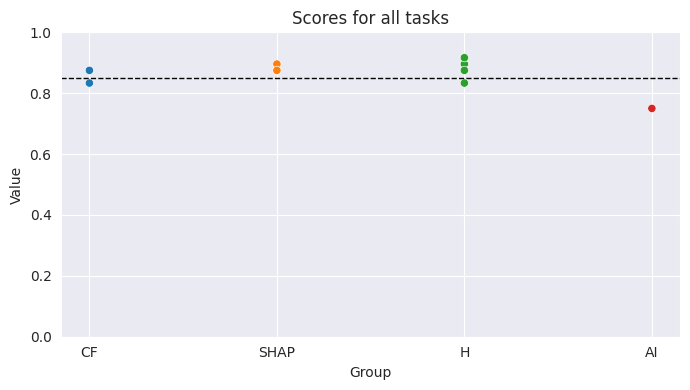

In [51]:
scatter_groups(all_scores, group_name="Group", title="Scores for all tasks", y_lim=(0, 1), y_line=0.85)


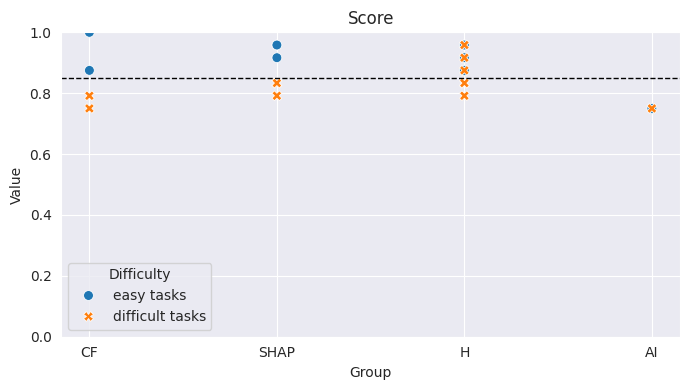

In [52]:
scatter_groups_nested(data_scores_difficulty, inner_name="Group", outer_name="Difficulty", title="Score", y_lim=(0, 1), y_line=0.85)

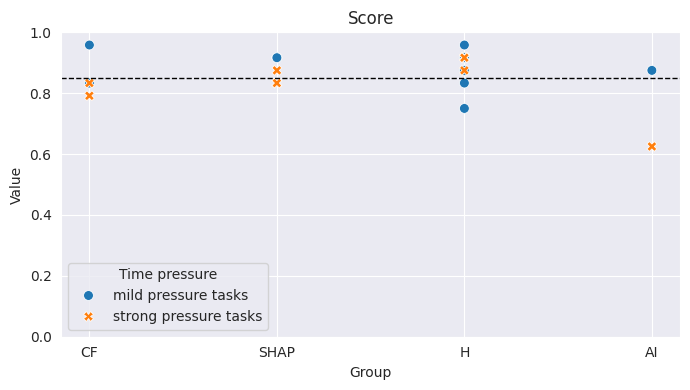

In [53]:
scatter_groups_nested(data_scores_pressure, inner_name="Group", outer_name="Time pressure", title="Score", y_lim=(0, 1), y_line=0.85)


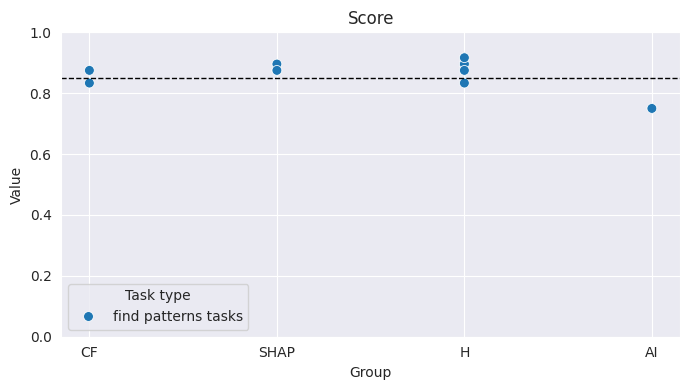

In [54]:
scatter_groups_nested(data_scores_tasks, inner_name="Group", outer_name="Task type", title="Score", y_lim=(0, 1), y_line=0.85)

In [55]:
all_reliance, all_overreliance

({'CF': [0.8541666666666666, 0.75],
  'SHAP': [0.7083333333333334, 0.7708333333333334, 0.7916666666666666],
  'H': [0.7291666666666666,
   0.75,
   0.7291666666666666,
   0.7083333333333334,
   0.75,
   0.6666666666666666],
  'AI': [0.7083333333333334]},
 {'CF': [0.5, 0.125],
  'SHAP': [0.0, 0.125, 0.125],
  'H': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'AI': [0.375]})

In [56]:
all_reliance_easy, all_overreliance_easy

({'CF': [0.9583333333333334, 0.8333333333333334],
  'SHAP': [0.75, 0.875, 0.7916666666666666],
  'H': [0.7083333333333334,
   0.7916666666666666,
   0.7916666666666666,
   0.75,
   0.7083333333333334,
   0.7083333333333334],
  'AI': [0.6666666666666666]},
 {'CF': [0.75, 0.0],
  'SHAP': [0.0, 0.25, 0.0],
  'H': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'AI': [0.25]})

In [57]:
all_reliance_difficult, all_overreliance_difficult

({'CF': [0.75, 0.6666666666666666],
  'SHAP': [0.6666666666666666, 0.6666666666666666, 0.7916666666666666],
  'H': [0.75,
   0.7083333333333334,
   0.6666666666666666,
   0.6666666666666666,
   0.7916666666666666,
   0.625],
  'AI': [0.75]},
 {'CF': [0.25, 0.25],
  'SHAP': [0.0, 0.0, 0.25],
  'H': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'AI': [0.5]})

In [58]:
all_reliance_mild, all_overreliance_mild

({'CF': [0.8333333333333334, 0.7916666666666666],
  'SHAP': [0.75, 0.75, 0.7916666666666666],
  'H': [0.7083333333333334,
   0.75,
   0.7083333333333334,
   0.6666666666666666,
   0.7916666666666666,
   0.5833333333333334],
  'AI': [0.7083333333333334]},
 {'CF': [0.5, 0.0],
  'SHAP': [0.0, 0.0, 0.0],
  'H': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'AI': [0.0]})

In [59]:
all_reliance_strong, all_overreliance_strong

({'CF': [0.875, 0.7083333333333334],
  'SHAP': [0.6666666666666666, 0.7916666666666666, 0.7916666666666666],
  'H': [0.75, 0.75, 0.75, 0.75, 0.7083333333333334, 0.75],
  'AI': [0.7083333333333334]},
 {'CF': [0.5, 0.25],
  'SHAP': [0.0, 0.25, 0.25],
  'H': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'AI': [0.75]})

In [60]:
all_reliance_findpatterns, all_overreliance_findpatterns

({'CF': [0.8541666666666666, 0.75],
  'SHAP': [0.7083333333333334, 0.7708333333333334, 0.7916666666666666],
  'H': [0.7291666666666666,
   0.75,
   0.7291666666666666,
   0.7083333333333334,
   0.75,
   0.6666666666666666],
  'AI': [0.7083333333333334]},
 {'CF': [0.5, 0.125],
  'SHAP': [0.0, 0.125, 0.125],
  'H': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  'AI': [0.375]})

In [61]:
all_reliance_countsym, all_overreliance_countsym

({'CF': [0.5833333333333334, 0.625],
  'SHAP': [0.5833333333333334, 0.6041666666666666, 0.6666666666666666],
  'H': [0.4791666666666667,
   0.6458333333333334,
   0.5625,
   0.5833333333333334,
   0.6875,
   0.6458333333333334]},
 {'CF': [0.625, 0.25],
  'SHAP': [0.125, 0.125, 0.625],
  'H': [0.375, 0.125, 0.25, 0.125, 0.25, 0.25]})

In [62]:
from pywebxaii.resretrieval import extract_total_times


def extract_times(results_dir, results_filenames_d):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)

            res_dict = load_json(curr_res_path)
            total_time, _ = extract_total_times(res_dict)

            output_res_d[group_key].append(total_time / 60)

    return output_res_d


In [63]:
times_data = extract_times(results_dir, results_filenames_d)

In [64]:
times_data

{'CF': [29.733116666666668, 34.010083333333334],
 'SHAP': [41.993233333333336, 41.341166666666666, 38.608716666666666],
 'H': [38.46868333333334,
  33.63203333333333,
  37.486,
  31.90195,
  34.397416666666665,
  35.13618333333333],
 'AI': [39.77816666666667]}

In [65]:
alltimes = []
for k, v in times_data.items():
    alltimes.extend(v)
print({f"median : {np.median(alltimes)}"})

{'median : 36.31109166666666'}


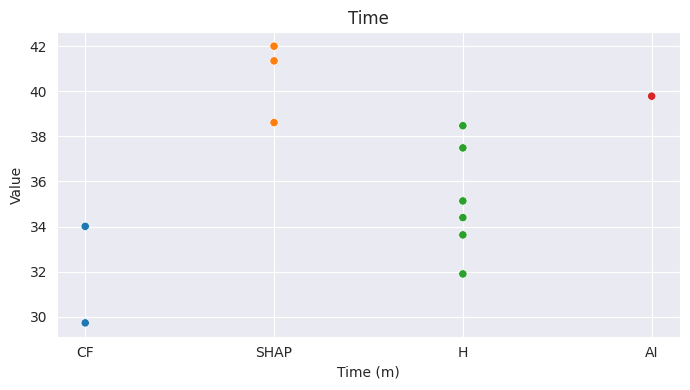

In [66]:
scatter_groups(times_data, "Time (m)", title="Time")


In [110]:
from pywebxaii.resretrieval import extract_p_questionnaire_results, get_protocol_entry_from_key


def extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = {"raw": {}, "values": {}, "times": {}}

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)

            # Iterating over all questionnaires keys
            for quest_key in quest_keys:

                curr_protocol_d = load_json(protocol_paths_d[group_key])
                try:
                    get_protocol_entry_from_key(curr_protocol_d, quest_key)
                except KeyError:
                    continue

                answers_raw, answers_values, quest_times = extract_p_questionnaire_results(load_json(curr_res_path),
                                                                                           quest_key,
                                                                                           protocol_d=curr_protocol_d)
                if quest_key not in output_res_d[group_key]["raw"]:
                    output_res_d[group_key]["raw"][quest_key] = []
                    output_res_d[group_key]["values"][quest_key] = []
                    output_res_d[group_key]["times"][quest_key] = []

                output_res_d[group_key]["raw"][quest_key].append(answers_raw)
                output_res_d[group_key]["values"][quest_key].append(answers_values)
                output_res_d[group_key]["times"][quest_key].append(quest_times)

    return output_res_d

In [111]:
def process_cogload(cogload_results):
    output_d = {}
    for k, v in cogload_results.items():
        output_d[k] = {}
        for session_id, results_list in v["raw"].items():

            if session_id == "mainexp_easy_mild_cogload":
                session_name = "easy;mild"
            elif session_id == "mainexp_easy_strong_cogload":
                session_name = "easy;strong"
            elif session_id == "mainexp_hard_mild_cogload":
                session_name = "hard;mild"
            elif session_id == "mainexp_hard_strong_cogload":
                session_name = "hard;strong"

            if session_id not in output_d:
                output_d[k][session_name] = []
            for result_arr in results_list:
                output_d[k][session_name].append(np.sum(result_arr))

    return output_d


In [112]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload",
              "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [113]:
cogload_results

{'CF': {'raw': {'mainexp_easy_mild_cogload': [array([5, 4, 5, 5, 5, 5], dtype=object),
    array([5, 2, 4, 2, 3, 2], dtype=object)],
   'mainexp_easy_strong_cogload': [array([6, 4, 5, 4, 4, 6], dtype=object),
    array([6, 3, 6, 4, 5, 5], dtype=object)],
   'mainexp_hard_mild_cogload': [array([5, 3, 3, 4, 3, 5], dtype=object),
    array([6, 2, 6, 0, 3, 5], dtype=object)],
   'mainexp_hard_strong_cogload': [array([4, 4, 4, 4, 3, 5], dtype=object),
    array([6, 4, 6, 5, 6, 6], dtype=object)]},
  'values': {'mainexp_easy_mild_cogload': [array(['', '', '', '', '', ''], dtype=object),
    array(['', '', '', '', '', ''], dtype=object)],
   'mainexp_easy_strong_cogload': [array(['Very high', '', '', '', '', 'Very high'], dtype=object),
    array(['Very high', '', 'Very high', '', '', ''], dtype=object)],
   'mainexp_hard_mild_cogload': [array(['', '', '', '', '', ''], dtype=object),
    array(['Very high', '', 'Very high', 'Perfect', '', ''], dtype=object)],
   'mainexp_hard_strong_cogload':

In [114]:
cogload_processed = process_cogload(cogload_results)

In [115]:
cogload_processed

{'CF': {'easy;mild': [29, 18],
  'easy;strong': [29, 29],
  'hard;mild': [23, 22],
  'hard;strong': [24, 33]},
 'SHAP': {'easy;mild': [12, 7, 17],
  'easy;strong': [23, 24, 20],
  'hard;mild': [26, 19, 26],
  'hard;strong': [27, 28, 27]},
 'H': {'easy;mild': [13, 4, 15, 23, 6, 8],
  'easy;strong': [30, 4, 21, 23, 19, 20],
  'hard;mild': [30, 7, 21, 21, 11, 27],
  'hard;strong': [32, 14, 25, 27, 27, 33]}}

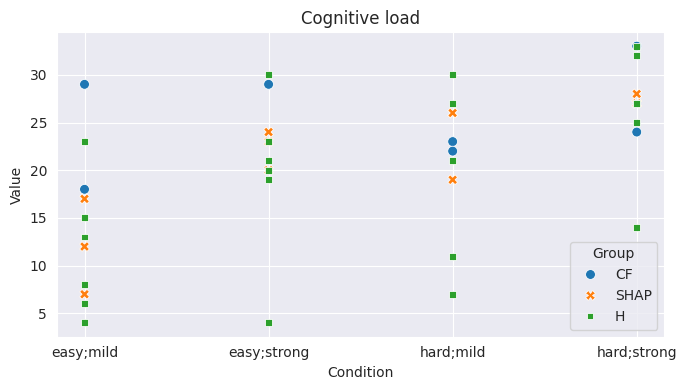

In [117]:
scatter_groups_nested(cogload_processed, inner_name="Condition", outer_name="Group" ,title="Cognitive load")

In [34]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload",
              "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [35]:
cogload_results

{'CF': {'raw': {'mainexp_easy_mild_cogload': [array([5, 4, 5, 5, 5, 5], dtype=object),
    array([5, 2, 4, 2, 3, 2], dtype=object)],
   'mainexp_easy_strong_cogload': [array([6, 4, 5, 4, 4, 6], dtype=object),
    array([6, 3, 6, 4, 5, 5], dtype=object)],
   'mainexp_hard_mild_cogload': [array([5, 3, 3, 4, 3, 5], dtype=object),
    array([6, 2, 6, 0, 3, 5], dtype=object)],
   'mainexp_hard_strong_cogload': [array([4, 4, 4, 4, 3, 5], dtype=object),
    array([6, 4, 6, 5, 6, 6], dtype=object)]},
  'values': {'mainexp_easy_mild_cogload': [array(['', '', '', '', '', ''], dtype=object),
    array(['', '', '', '', '', ''], dtype=object)],
   'mainexp_easy_strong_cogload': [array(['Very high', '', '', '', '', 'Very high'], dtype=object),
    array(['Very high', '', 'Very high', '', '', ''], dtype=object)],
   'mainexp_hard_mild_cogload': [array(['', '', '', '', '', ''], dtype=object),
    array(['Very high', '', 'Very high', 'Perfect', '', ''], dtype=object)],
   'mainexp_hard_strong_cogload':

In [36]:
extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_1"])


{'CF': {'raw': {'attentioncheck_1': [array([2, 6], dtype=object),
    array([2, 6], dtype=object)]},
  'values': {'attentioncheck_1': [array(['(3) Somewhat Disagree', '(7) Strongly Agree'], dtype=object),
    array(['(3) Somewhat Disagree', '(7) Strongly Agree'], dtype=object)]},
  'times': {'attentioncheck_1': [27410, 15054]}},
 'SHAP': {'raw': {'attentioncheck_1': [array([2, 6], dtype=object),
    array([2, 6], dtype=object),
    array([4, 6], dtype=object)]},
  'values': {'attentioncheck_1': [array(['(3) Somewhat Disagree', '(7) Strongly Agree'], dtype=object),
    array(['(3) Somewhat Disagree', '(7) Strongly Agree'], dtype=object),
    array(['(5) Somewhat Agree', '(7) Strongly Agree'], dtype=object)]},
  'times': {'attentioncheck_1': [34614, 40208, 17373]}},
 'H': {'raw': {'attentioncheck_1': [array([4, 6], dtype=object),
    array([0, 0], dtype=object),
    array([2, 6], dtype=object),
    array([2, 6], dtype=object),
    array([2, 6], dtype=object),
    array([2, 6], dtype=obje

In [37]:
def process_reliance_list_data(reliance_data_list):

    output_reliance = None
    output_trust = None
    output_xai_reliance = None

    if len(reliance_data_list) > 0:
        output_reliance = reliance_data_list[0]
    if len(reliance_data_list) > 1:
        output_trust = reliance_data_list[1]
    if len(reliance_data_list) > 2:
        output_xai_reliance = reliance_data_list[2]

    return output_reliance, output_trust, output_xai_reliance

def extract_declared_reliance_data(results_dir, results_filenames_d, protocol_paths_d):

    output_d = {}

    form_keys = ["mainexp_easy_mild_reliance",
            "mainexp_easy_strong_reliance",
            "mainexp_hard_mild_reliance",
            "mainexp_hard_strong_reliance"]

    data = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, form_keys)

    for key_group, data in data.items():
        output_d[key_group] = {}

        for form_key in form_keys:
            output_d[key_group][form_key] = {
                "reliance": [],
                "trust": [],
                "xai_reliance": [],
            }

            if form_key not in data["raw"]:
                continue

            for arr in data["raw"][form_key]:
                reliance, trust, xai_reliance = process_reliance_list_data(arr)
                output_d[key_group][form_key]["reliance"].append(reliance)
                output_d[key_group][form_key]["trust"].append(trust)
                output_d[key_group][form_key]["xai_reliance"].append(xai_reliance)

    return output_d


In [38]:
processed_reliance_data = extract_declared_reliance_data(results_dir, results_filenames_d, protocol_paths_d)


In [39]:
processed_reliance_data

{'CF': {'mainexp_easy_mild_reliance': {'reliance': [3, 1],
   'trust': [3, 2],
   'xai_reliance': [4, 2]},
  'mainexp_easy_strong_reliance': {'reliance': [6, 5],
   'trust': [6, 3],
   'xai_reliance': [6, 2]},
  'mainexp_hard_mild_reliance': {'reliance': [4, 3],
   'trust': [3, 2],
   'xai_reliance': [2, 4]},
  'mainexp_hard_strong_reliance': {'reliance': [6, 6],
   'trust': [5, 2],
   'xai_reliance': [5, 4]}},
 'SHAP': {'mainexp_easy_mild_reliance': {'reliance': [2, 1, 5],
   'trust': [2, 1, 4],
   'xai_reliance': [3, 3, 6]},
  'mainexp_easy_strong_reliance': {'reliance': [1, 4, 5],
   'trust': [1, 2, 4],
   'xai_reliance': [3, 3, 5]},
  'mainexp_hard_mild_reliance': {'reliance': [1, 1, 5],
   'trust': [1, 1, 4],
   'xai_reliance': [3, 1, 6]},
  'mainexp_hard_strong_reliance': {'reliance': [4, 5, 5],
   'trust': [2, 4, 5],
   'xai_reliance': [4, 4, 6]}},
 'H': {'mainexp_easy_mild_reliance': {'reliance': [],
   'trust': [],
   'xai_reliance': []},
  'mainexp_easy_strong_reliance': {'re

In [40]:
def get_data_for_reliance_plots(processed_reliance_data, target_key):

    output_d = {k: {} for k in results_filenames_d.keys()}

    for group_key, group_data in processed_reliance_data.items():
        for form_key, form_data in group_data.items():
            output_d[group_key][form_key] = form_data[target_key]

    return output_d

def plot_grouped_histograms(data, xlim, bins=20, alpha=0.5, figsize=(12, 6)):
    """
    Plots histograms for nested group data.

    Parameters:
        data (dict):
            {
                "group1": {"groupA": [...], "groupB": [...], ...},
                "group2": {"groupA": [...], "groupB": [...], ...},
                ...
            }
        bins (int): Number of bins for histograms.
        alpha (float): Transparency for the overlapping histograms.
        figsize (tuple): Figure size.
    """

    # Get all subgroup names (e.g., groupA, groupB...)
    subgroups = sorted({sg for g in data.values() for sg in g.keys()})

    # Create one subplot per subgroup
    fig, axes = plt.subplots(1, len(subgroups), figsize=figsize, squeeze=False)
    axes = axes[0]

    # Prepare colors (matplotlib will cycle them automatically)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_map = {gname: colors[i % len(colors)] for i, gname in enumerate(data.keys())}

    for ax, subgroup in zip(axes, subgroups):
        for group_name, group_dict in data.items():
            if subgroup in group_dict:
                values = group_dict[subgroup]
                if values:  # skip empty lists
                    ax.hist(values, bins=bins, alpha=alpha,
                            label=group_name, color=color_map[group_name])

        ax.set_title(subgroup)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.set_xlim(xlim)
        ax.legend()

    plt.tight_layout()
    plt.show()


In [41]:
declared_reliance_plot_data = get_data_for_reliance_plots(processed_reliance_data, "reliance")
declared_trust_plot_data = get_data_for_reliance_plots(processed_reliance_data, "trust")
declared_xai_reliance_plot_data = get_data_for_reliance_plots(processed_reliance_data, "xai_reliance")

In [42]:
declared_reliance_plot_data

{'CF': {'mainexp_easy_mild_reliance': [3, 1],
  'mainexp_easy_strong_reliance': [6, 5],
  'mainexp_hard_mild_reliance': [4, 3],
  'mainexp_hard_strong_reliance': [6, 6]},
 'SHAP': {'mainexp_easy_mild_reliance': [2, 1, 5],
  'mainexp_easy_strong_reliance': [1, 4, 5],
  'mainexp_hard_mild_reliance': [1, 1, 5],
  'mainexp_hard_strong_reliance': [4, 5, 5]},
 'H': {'mainexp_easy_mild_reliance': [],
  'mainexp_easy_strong_reliance': [],
  'mainexp_hard_mild_reliance': [],
  'mainexp_hard_strong_reliance': []}}

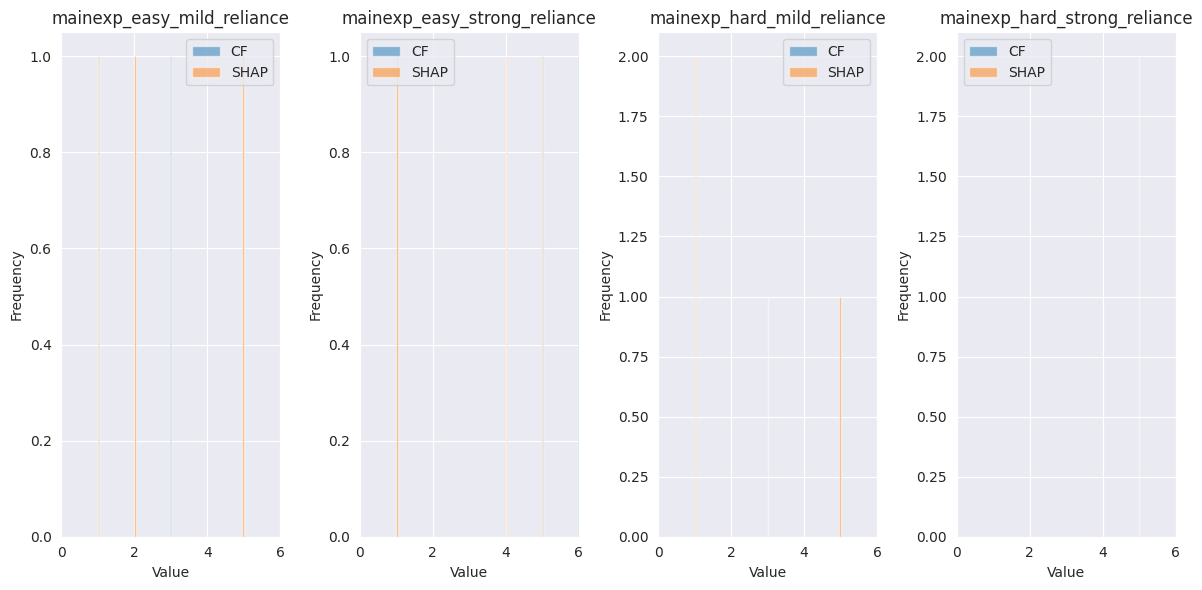

In [43]:
plot_grouped_histograms(declared_reliance_plot_data, bins=100, xlim=(0, 6), figsize=(12, 6))


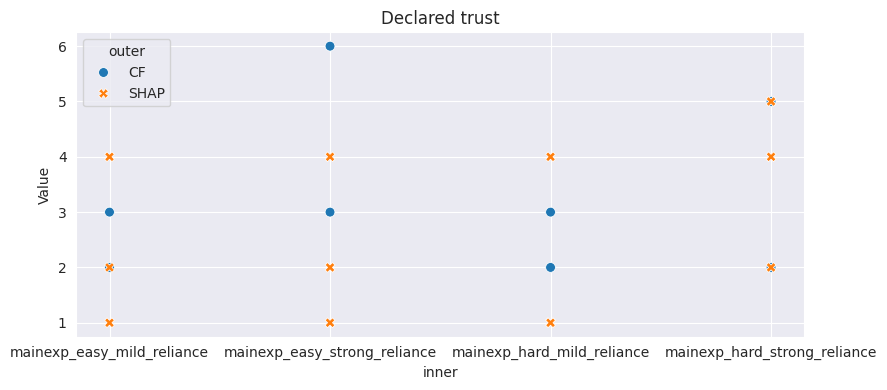

In [44]:
scatter_groups_nested(declared_trust_plot_data, title="Declared trust", figsize=(9, 4))


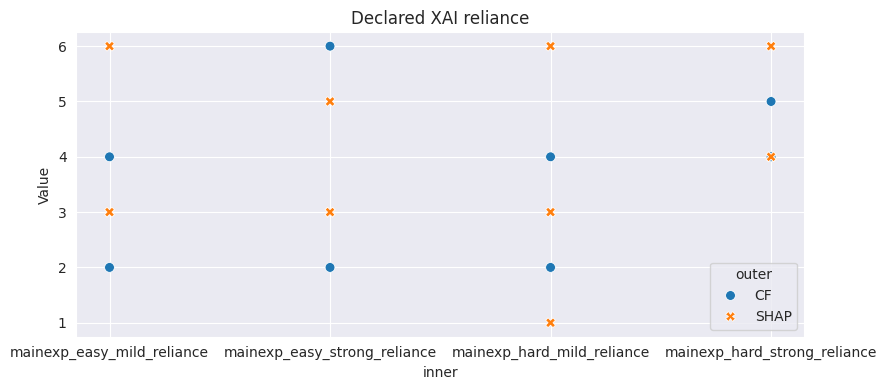

In [45]:
scatter_groups_nested(declared_xai_reliance_plot_data, title="Declared XAI reliance", figsize=(9, 4))


In [46]:
declared_xai_reliance_plot_data

{'CF': {'mainexp_easy_mild_reliance': [4, 2],
  'mainexp_easy_strong_reliance': [6, 2],
  'mainexp_hard_mild_reliance': [2, 4],
  'mainexp_hard_strong_reliance': [5, 4]},
 'SHAP': {'mainexp_easy_mild_reliance': [3, 3, 6],
  'mainexp_easy_strong_reliance': [3, 3, 5],
  'mainexp_hard_mild_reliance': [3, 1, 6],
  'mainexp_hard_strong_reliance': [4, 4, 6]},
 'H': {'mainexp_easy_mild_reliance': [],
  'mainexp_easy_strong_reliance': [],
  'mainexp_hard_mild_reliance': [],
  'mainexp_hard_strong_reliance': []}}